## 0. Imports

In [34]:
import os
import re
import glob
import re
from google.colab import files

import pandas as pd
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple, Set

## 1. Helper functions for computing metrics to evaluate accuracy

Brief justification of selected metrics:

- **Structural Hamming Distance (SHD)**: We use SHD because it directly measures how many edge edits are needed to transform the reconstructed directed graph into the ground-truth graph: each missing true edge or extra predicted edge contributes one unit (i.e., $\mathrm{SHD} = \lvert E_{\mathrm{true}} \,\Delta\, E_{\mathrm{pred}} \rvert,$ where $\Delta$ denotes the symmetric difference of edge sets). This makes the error magnitude immediately interpretable as a count of structural mistakes, and it aligns well with the goal of assessing how dataset characteristics and scoring functions (MDL vs BDE) affect the accuracy of inferred network connectivity.

- **Jaccard distance on directed edge sets**: We additionally use Jaccard distance because it provides a normalized measure of dissimilarity between the predicted and true edge sets: $d_J = 1 - \frac{\lvert E_{\mathrm{true}}\cap E_{\mathrm{pred}} \rvert}{\lvert E_{\mathrm{true}}\cup E_{\mathrm{pred}} \rvert}.$ Unlike SHD, it is bounded in $[0,1]$, so results are easier to compare across conditions that change the number of predicted edges (e.g., different sampling/trajectory settings and different scoring functions). This complements SHD by evaluating overlap proportion rather than absolute edit count.

Together, SHD (absolute edge-edit error) and Jaccard distance (normalized edge-set overlap) provide complementary views of structural reconstruction quality across datasets and scoring functions.

In addition to SHD and Jaccard distance, we report edge-level precision, recall and the F1-score by treating the presence of each directed edge as a binary decision. These measures decompose structural errors into false positives (spurious inferred edges) and false negatives (missed true edges), which helps interpret whether a method tends to over-connect or under-connect the network. The F1-score provides a single-number summary that balances precision and recall for compact comparison across conditions.

In [35]:
Edge = Tuple[str, str]  # (src, dst)

In [36]:
def shd(e_true: Set[Edge], e_pred: Set[Edge]) -> int:
    """Structural Hamming Distance = |E_true Δ E_pred|."""
    return len(e_true.symmetric_difference(e_pred))

def jaccard_distance(e_true: Set[Edge], e_pred: Set[Edge]) -> float:
    """1 - |intersection|/|union| on directed edge sets."""
    union = e_true | e_pred
    if not union:
        return 0.0
    inter = e_true & e_pred
    return 1.0 - (len(inter) / len(union))

def precision_recall_f1(e_true: Set[Edge], e_pred: Set[Edge]):
    tp = len(e_true & e_pred)
    fp = len(e_pred - e_true)
    fn = len(e_true - e_pred)
    precision = tp / (tp + fp) if (tp + fp) else 0.0
    recall = tp / (tp + fn) if (tp + fn) else 0.0
    f1 = (2 * precision * recall / (precision + recall)) if (precision + recall) else 0.0
    return precision, recall, f1

In [37]:
def read_sif_edges(path: str) -> List[Tuple[str, float, str]]:
    """
    Read SIF lines of the form: src <whitespace> prob <whitespace> dst
    Returns list of (src, prob, dst).
    """
    rows = []
    with open(path, "r", encoding="utf-8", errors="replace") as f:
        for line in f:
            line = line.strip()
            if not line or line.startswith("#"):
                continue
            parts = re.split(r"\s+", line)
            if len(parts) < 3:
                continue
            src, w, dst = parts[0], parts[1], parts[2]
            try:
                p = float(w)
            except ValueError:
                continue
            rows.append((src, p, dst))
    return rows

def binarize_edges(rows: List[Tuple[str, float, str]], method: str = "topk",
                   threshold: float = 0.5, topk: int = 3) -> Set[Edge]:
    """
    Convert weighted edges into a binary directed edge set.
    - threshold: keep edges with prob >= threshold
    - topk: for each destination node, keep top-k incoming edges by prob
    """
    if method == "threshold":
        return {(src, dst) for (src, p, dst) in rows if p >= threshold}

    if method == "topk":
        by_dst: Dict[str, List[Tuple[str, float]]] = {}
        for src, p, dst in rows:
            by_dst.setdefault(dst, []).append((src, p))

        edges: Set[Edge] = set()
        for dst, incoming in by_dst.items():
            incoming_sorted = sorted(incoming, key=lambda t: t[1], reverse=True)
            for src, _p in incoming_sorted[:topk]:
                edges.add((src, dst))
        return edges

    raise ValueError("method must be 'threshold' or 'topk'")

In [38]:
def gt_edges_as_strings(n_nodes: int, gt_map: Dict[int, List[Tuple[int, int]]]) -> Set[Edge]:
    """Convert integer edges like (2,3) to ('G2','G3')."""
    return {(f"G{u}", f"G{v}") for (u, v) in gt_map[n_nodes]}

## 2. Pipeline building a "manifest dataframe" from files in gridsearches.zip

The following code builds a DataFrame where each row corresponds to a .sif file, with parsed metadata.

In [39]:
def collect_all_sif_paths(root: str) -> list[str]:
    """
    Collect all .sif files under:
      root/gridsearch1/results MDL/
      root/gridsearch1/results BDE/
      root/gridsearch2/results MDL/
      root/gridsearch2/results BDE/
    """
    patterns = [
        os.path.join(root, "gridsearch1", "results MDL", "*.sif"),
        os.path.join(root, "gridsearch1", "results BDE", "*.sif"),
        os.path.join(root, "gridsearch2", "results MDL", "*.sif"),
        os.path.join(root, "gridsearch2", "results BDE", "*.sif"),
        os.path.join(root, "gridsearch3", "results MDL", "*.sif"),
        os.path.join(root, "gridsearch3", "results BDE", "*.sif"),
    ]
    paths: list[str] = []
    for pat in patterns:
        paths.extend(glob.glob(pat, recursive=True))
    return sorted(set(paths))

def parse_metadata_from_path_and_filename(path: str) -> dict:
    """
    Parse metadata from:
    - folder path: gridsearch (1/2) and score (MDL/BDE)
    - filename:
        gridsearch1: <mode>_<traj_len>_<attr_flag>_<score>.sif
                    e.g. s_50_1_MDL.sif
          rules: mode a/s, traj_len 10/20/50, attr_flag 0/1
        gridsearch2: <n_nodes>_<mode>_<step>_<score>.sif
                    e.g. 5_s_3_MDL.sif
          rules: n_nodes 5/10/16, mode a/s, step 1/2/3
    """
    norm = path.replace("\\", "/")
    filename = os.path.basename(path)

    # gridsearch inferred from path
    if "/gridsearch1/" in norm:
        gridsearch = "gridsearch1"
    elif "/gridsearch2/" in norm:
        gridsearch = "gridsearch2"
    elif "/gridsearch3/" in norm:
        gridsearch = "gridsearch3"
    else:
        gridsearch = None

    # score inferred from path folder
    if "/results MDL/" in norm:
        score = "MDL"
    elif "/results BDE/" in norm:
        score = "BDE"
    else:
        score = None

    meta = {
        "gridsearch": gridsearch,
        "score": score,
        "file": filename,
        "path": path,
        "traj_len": None,
        "attr_flag": None,
        "n_nodes": None,
        "step": None,
        "mode": None,
    }

    # gridsearch1 and gridsearch3 filename pattern: s_50_1_MDL.sif
    m1 = re.match(
        r"^(?P<mode>[asAS])_(?P<traj_len>\d+)_(?P<attr_flag>[01])_(?P<score>[A-Za-z]+)\.sif$",
        filename
    )
    if m1:
        meta["mode"] = m1.group("mode").lower()
        meta["traj_len"] = int(m1.group("traj_len"))
        meta["attr_flag"] = int(m1.group("attr_flag"))
        meta["score"] = meta["score"] or m1.group("score").upper()
        if meta["gridsearch"] in ("gridsearch1",):
            meta["n_nodes"] = 5
        elif meta["gridsearch"] in ("gridsearch3",):
            meta["n_nodes"] = 10
        return meta

    # gridsearch2 filename pattern: 5_s_3_MDL.sif
    m2 = re.match(
        r"^(?P<n_nodes>\d+)_(?P<mode>[asAS])_(?P<step>[123])_(?P<score>[A-Za-z]+)\.sif$",
        filename
    )
    if m2:
        meta["n_nodes"] = int(m2.group("n_nodes"))
        meta["mode"] = m2.group("mode").lower()
        meta["step"] = int(m2.group("step"))
        meta["score"] = meta["score"] or m2.group("score").upper()
        return meta

    # Fallback: infer score from filename if not found in folder
    if meta["score"] is None:
        up = filename.upper()
        if "MDL" in up:
            meta["score"] = "MDL"
        elif "BDE" in up:
            meta["score"] = "BDE"

    return meta

def build_manifest_dataframe(root: str) -> pd.DataFrame:
    """
    Build a DataFrame where each row corresponds to a .sif file,
    with parsed metadata.
    """
    paths = collect_all_sif_paths(root)
    if not paths:
        raise FileNotFoundError(
            f"No .sif files found under: {root}. Check the expected folder structure."
        )

    records = [parse_metadata_from_path_and_filename(p) for p in paths]
    df = pd.DataFrame(records)

    preferred_cols = [
        "gridsearch", "score", "n_nodes", "mode", "traj_len", "attr_flag", "step",
        "file", "path"
    ]
    cols = [c for c in preferred_cols if c in df.columns]
    df = df[cols].sort_values(
        ["gridsearch", "score", "n_nodes", "mode", "traj_len", "attr_flag", "step", "file"],
        na_position="last"
    ).reset_index(drop=True)

    return df

## 3. Loading gridsearches_loops.zip and creating a final dataframe out of all files

Assume we have access to "gridsearches-3.zip"

In [40]:
_ = files.upload()

Saving gridsearches-3.zip to gridsearches-3.zip


In [41]:
!unzip -o gridsearches-3.zip -d . > /dev/null

In [42]:
root = "gridsearches-3"
manifest_df = build_manifest_dataframe(root)
manifest_df.head()

,gridsearch,score,n_nodes,mode,traj_len,attr_flag,step,file,path
0,gridsearch1,BDE,5,a,10.0,0.0,NaN,a_10_0_BDE.sif,gridsearches-3/gridsearch1/results BDE/a_10_0_...
1,gridsearch1,BDE,5,a,10.0,1.0,NaN,a_10_1_BDE.sif,gridsearches-3/gridsearch1/results BDE/a_10_1_...
2,gridsearch1,BDE,5,a,20.0,0.0,NaN,a_20_0_BDE.sif,gridsearches-3/gridsearch1/results BDE/a_20_0_...
3,gridsearch1,BDE,5,a,20.0,1.0,NaN,a_20_1_BDE.sif,gridsearches-3/gridsearch1/results BDE/a_20_1_...
4,gridsearch1,BDE,5,a,50.0,0.0,NaN,a_50_0_BDE.sif,gridsearches-3/gridsearch1/results BDE/a_50_0_...


## 4. Results for reconstructed networks in Part I of project:

In [43]:
# Ground-truth edge lists as tuples (src, dst) using integer node indices for gridsearches
GT_MAP_gridsearches = {
    5:  [(2, 2), (4, 3), (3, 4)],
    10: [(1, 1), (2, 1), (6, 1),
         (1, 2), (3, 2), (4, 2),
         (2, 3), (5, 3),
         (5, 4), (6, 4), (8, 4),
         (0, 5), (7, 5), (8, 5),
         (1, 6), (8, 6), (9, 6),
         (1, 9), (4, 9), (6, 9)],
    16: [(8, 0), (13, 0),
         (2, 2),
         (2, 3), (5, 3), (11, 3),
         (1, 4),
         (4, 5), (11, 5), (14, 5),
         (15, 6),
         (1, 8),
         (2, 9), (6, 9), (14, 9),
         (4, 10),
         (0, 11), (4, 11),
         (12, 12),
         (9, 13),
         (4, 15), (5, 15), (14, 15)],
}

In [44]:
def evaluate_manifest(manifest_df: pd.DataFrame, method: str = "topk",
                      threshold: float = 0.5, topk: int = 3) -> pd.DataFrame:
    """
    For each row in manifest_df:
    - select ground truth using n_nodes
    - read the .sif file
    - binarize predicted edges
    - compute SHD + Jaccard distance (+ precision/recall/F1)
    Returns a new DataFrame with metrics added.
    """
    records = []
    for _, row in manifest_df.iterrows():
        path = row["path"]
        n_nodes = int(row["n_nodes"])  # should be 5/10/16

        e_true = gt_edges_as_strings(n_nodes, GT_MAP_gridsearches)

        rows = read_sif_edges(path)
        e_pred = binarize_edges(rows, method=method, threshold=threshold, topk=topk)

        shd_val = shd(e_true, e_pred)
        jac_val = jaccard_distance(e_true, e_pred)
        prec, rec, f1 = precision_recall_f1(e_true, e_pred)

        records.append({
            "SHD": shd_val,
            "JaccardDist": jac_val,
            "Precision": prec,
            "Recall": rec,
            "F1": f1,
            "n_true_edges": len(e_true),
            "n_pred_edges": len(e_pred),
        })

    metrics_df = pd.DataFrame(records)
    out = pd.concat([manifest_df.reset_index(drop=True), metrics_df], axis=1)

    sort_cols = ["gridsearch", "n_nodes", "score", "mode", "traj_len", "attr_flag", "step", "file"]
    sort_cols = [c for c in sort_cols if c in out.columns]
    out = out.sort_values(sort_cols, na_position="last").reset_index(drop=True)

    out["binarize_method"] = method
    out["threshold"] = threshold if method == "threshold" else None
    out["topk"] = topk if method == "topk" else None
    return out

In [45]:
results_df = evaluate_manifest(manifest_df, method="threshold", threshold=0.5)
results_df

,gridsearch,score,n_nodes,mode,traj_len,attr_flag,step,file,path,SHD,JaccardDist,Precision,Recall,F1,n_true_edges,n_pred_edges,binarize_method,threshold,topk
0,gridsearch1,BDE,5,a,10.0,0.0,NaN,a_10_0_BDE.sif,gridsearches-3/gridsearch1/results BDE/a_10_0_...,4,0.571429,0.428571,1.00,0.600000,3,7,threshold,0.5,None
1,gridsearch1,BDE,5,a,10.0,1.0,NaN,a_10_1_BDE.sif,gridsearches-3/gridsearch1/results BDE/a_10_1_...,4,0.571429,0.428571,1.00,0.600000,3,7,threshold,0.5,None
2,gridsearch1,BDE,5,a,20.0,0.0,NaN,a_20_0_BDE.sif,gridsearches-3/gridsearch1/results BDE/a_20_0_...,4,0.571429,0.428571,1.00,0.600000,3,7,threshold,0.5,None
3,gridsearch1,BDE,5,a,20.0,1.0,NaN,a_20_1_BDE.sif,gridsearches-3/gridsearch1/results BDE/a_20_1_...,4,0.571429,0.428571,1.00,0.600000,3,7,threshold,0.5,None
4,gridsearch1,BDE,5,a,50.0,0.0,NaN,a_50_0_BDE.sif,gridsearches-3/gridsearch1/results BDE/a_50_0_...,4,0.571429,0.428571,1.00,0.600000,3,7,threshold,0.5,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,gridsearch3,MDL,10,s,10.0,1.0,NaN,s_10_1_MDL.sif,gridsearches-3/gridsearch3/results MDL/s_10_1_...,10,0.500000,1.000000,0.50,0.666667,20,10,threshold,0.5,None
80,gridsearch3,MDL,10,s,20.0,0.0,NaN,s_20_0_MDL.sif,gridsearches-3/gridsearch3/results MDL/s_20_0_...,7,0.350000,1.000000,0.65,0.787879,20,13,threshold,0.5,None
81,gridsearch3,MDL,10,s,20.0,1.0,NaN,s_20_1_MDL.sif,gridsearches-3/gridsearch3/results MDL/s_20_1_...,6,0.300000,1.000000,0.70,0.823529,20,14,threshold,0.5,None
82,gridsearch3,MDL,10,s,50.0,0.0,NaN,s_50_0_MDL.sif,gridsearches-3/gridsearch3/results MDL/s_50_0_...,5,0.217391,0.857143,0.90,0.878049,20,21,threshold,0.5,None


For nicer and clearer formatting we will divide this table into one for gridsearch1 and one for gridsearch2

### Gridsearch 1 results:

In [46]:
def pivot_gs1_mdl_vs_bde(results_df: pd.DataFrame) -> pd.DataFrame:
    gs1 = results_df[results_df["gridsearch"] == "gridsearch1"].copy()

    summary = (
        gs1.groupby(["mode", "traj_len", "attr_flag", "score"], dropna=False)
           .agg(
               SHD=("SHD", "mean"),
               Jaccard=("JaccardDist", "mean"),
               Precision=("Precision", "mean"),
               Recall=("Recall", "mean"),
               F1=("F1", "mean"),
           )
           .reset_index()
    )

    pivot = summary.pivot_table(
        index=["mode", "traj_len", "attr_flag"],
        columns="score",
        values=["SHD", "Jaccard", "Precision", "Recall", "F1"],
        aggfunc="mean"
    ).sort_index()

    # Enforce metric order
    metric_order = ["SHD", "Jaccard", "Precision", "Recall", "F1"]
    pivot = pivot.reindex(metric_order, axis=1, level=0)

    # Flatten columns into e.g. "SHD (MDL)"
    pivot.columns = [f"{metric} ({score})" for (metric, score) in pivot.columns]
    return pivot.round(4)

gs1_pivot = pivot_gs1_mdl_vs_bde(results_df)
gs1_pivot

SHD (BDE)  SHD (MDL)  Jaccard (BDE)  Jaccard (MDL)  \
mode traj_len attr_flag                                                       
a    10.0     0.0              4.0        4.0         0.5714         0.5714   
              1.0              4.0        4.0         0.5714         0.5714   
     20.0     0.0              4.0        4.0         0.5714         0.5714   
              1.0              4.0        4.0         0.5714         0.5714   
     50.0     0.0              4.0        4.0         0.5714         0.5714   
              1.0              4.0        4.0         0.5714         0.5714   
s    10.0     0.0              0.0        0.0         0.0000         0.0000   
              1.0              0.0        0.0         0.0000         0.0000   
     20.0     0.0              0.0        0.0         0.0000         0.0000   
              1.0              0.0        0.0         0.0000         0.0000   
     50.0     0.0              0.0        0.0         0.0000         0.0000   
              1.0              0.0        0.0         0.0000         0.0000   

                         Precision (BDE)  Precision (MDL)  Recall (BDE)  \
mode traj_len attr_flag                                                   
a    10.0     0.0                 0.4286           0.4286           1.0   
              1.0                 0.4286           0.4286           1.0   
     20.0     0.0                 0.4286           0.4286           1.0   
              1.0                 0.4286           0.4286           1.0   
     50.0     0.0                 0.4286           0.4286           1.0   
              1.0                 0.4286           0.4286           1.0   
s    10.0     0.0                 1.0000           1.0000           1.0   
              1.0                 1.0000           1.0000           1.0   
     20.0     0.0                 1.0000           1.0000           1.0   
              1.0                 1.0000           1.0000           1.0   
     50.0     0.0                 1.0000           1.0000           1.0   
              1.0                 1.0000           1.0000           1.0   

                         Recall (MDL)  F1 (BDE)  F1 (MDL)  
mode traj_len attr_flag                                    
a    10.0     0.0                 1.0       0.6       0.6  
              1.0                 1.0       0.6       0.6  
     20.0     0.0                 1.0       0.6       0.6  
              1.0                 1.0       0.6       0.6  
     50.0     0.0                 1.0       0.6       0.6  
              1.0                 1.0       0.6       0.6  
s    10.0     0.0                 1.0       1.0       1.0  
              1.0                 1.0       1.0       1.0  
     20.0     0.0                 1.0       1.0       1.0  
              1.0                 1.0       1.0       1.0  
     50.0     0.0                 1.0       1.0       1.0  
              1.0                 1.0       1.0       1.0

### Gridsearch 2 results:

In [47]:
def pivot_gs2_mdl_vs_bde(results_df: pd.DataFrame) -> pd.DataFrame:
    gs2 = results_df[results_df["gridsearch"] == "gridsearch2"].copy()

    summary = (
        gs2.groupby(["n_nodes", "mode", "step", "score"], dropna=False)
           .agg(
               SHD=("SHD", "mean"),
               Jaccard=("JaccardDist", "mean"),
               Precision=("Precision", "mean"),
               Recall=("Recall", "mean"),
               F1=("F1", "mean"),
           )
           .reset_index()
    )

    pivot = summary.pivot_table(
        index=["n_nodes", "mode", "step"],
        columns="score",
        values=["SHD", "Jaccard", "Precision", "Recall", "F1"],
        aggfunc="mean"
    ).sort_index()

    metric_order = ["SHD", "Jaccard", "Precision", "Recall", "F1"]
    pivot = pivot.reindex(metric_order, axis=1, level=0)

    pivot.columns = [f"{metric} ({score})" for (metric, score) in pivot.columns]
    return pivot.round(4)

gs2_pivot = pivot_gs2_mdl_vs_bde(results_df)
gs2_pivot

SHD (BDE)  SHD (MDL)  Jaccard (BDE)  Jaccard (MDL)  \
n_nodes mode step                                                       
5       a    1.0         4.0        4.0         0.5714         0.5714   
             2.0         5.0        5.0         0.7143         0.7143   
             3.0         3.0        3.0         0.6000         0.6000   
        s    1.0         0.0        0.0         0.0000         0.0000   
             2.0         4.0        4.0         0.8000         0.8000   
             3.0         0.0        0.0         0.0000         0.0000   
10      a    1.0        27.0       28.0         0.9000         0.9032   
             2.0        19.0       19.0         0.7600         0.7600   
             3.0        27.0       27.0         0.9310         0.9310   
        s    1.0        10.0       10.0         0.5000         0.5000   
             2.0        20.0       21.0         0.9091         0.9130   
             3.0        20.0       20.0         0.9524         0.9524   
16      a    1.0        33.0       32.0         0.8919         0.8649   
             2.0        32.0       33.0         0.8421         0.8684   
             3.0        33.0       31.0         0.8684         0.8378   
        s    1.0        11.0       10.0         0.4783         0.4348   
             2.0        27.0       27.0         0.9310         0.9310   
             3.0        21.0       21.0         0.8750         0.8750   

                   Precision (BDE)  Precision (MDL)  Recall (BDE)  \
n_nodes mode step                                                   
5       a    1.0            0.4286           0.4286        1.0000   
             2.0            0.3333           0.3333        0.6667   
             3.0            0.5000           0.5000        0.6667   
        s    1.0            1.0000           1.0000        1.0000   
             2.0            0.3333           0.3333        0.3333   
             3.0            1.0000           1.0000        1.0000   
10      a    1.0            0.2308           0.2143        0.1500   
             2.0            0.5455           0.5455        0.3000   
             3.0            0.1818           0.1818        0.1000   
        s    1.0            1.0000           1.0000        0.5000   
             2.0            0.5000           0.4000        0.1000   
             3.0            0.5000           0.5000        0.0500   
16      a    1.0            0.2222           0.2632        0.1739   
             2.0            0.2857           0.2500        0.2609   
             3.0            0.2500           0.3000        0.2174   
        s    1.0            1.0000           1.0000        0.5217   
             2.0            0.2500           0.2500        0.0870   
             3.0            0.7500           0.7500        0.1304   

                   Recall (MDL)  F1 (BDE)  F1 (MDL)  
n_nodes mode step                                    
5       a    1.0         1.0000    0.6000    0.6000  
             2.0         0.6667    0.4444    0.4444  
             3.0         0.6667    0.5714    0.5714  
        s    1.0         1.0000    1.0000    1.0000  
             2.0         0.3333    0.3333    0.3333  
             3.0         1.0000    1.0000    1.0000  
10      a    1.0         0.1500    0.1818    0.1765  
             2.0         0.3000    0.3871    0.3871  
             3.0         0.1000    0.1290    0.1290  
        s    1.0         0.5000    0.6667    0.6667  
             2.0         0.1000    0.1667    0.1600  
             3.0         0.0500    0.0909    0.0909  
16      a    1.0         0.2174    0.1951    0.2381  
             2.0         0.2174    0.2727    0.2326  
             3.0         0.2609    0.2326    0.2791  
        s    1.0         0.5652    0.6857    0.7222  
             2.0         0.0870    0.1290    0.1290  
             3.0         0.1304    0.2222    0.2222

#### Analysis by Jaccard metric:

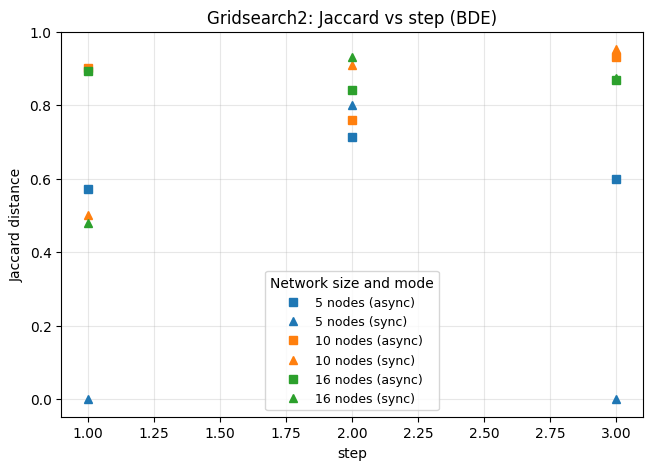

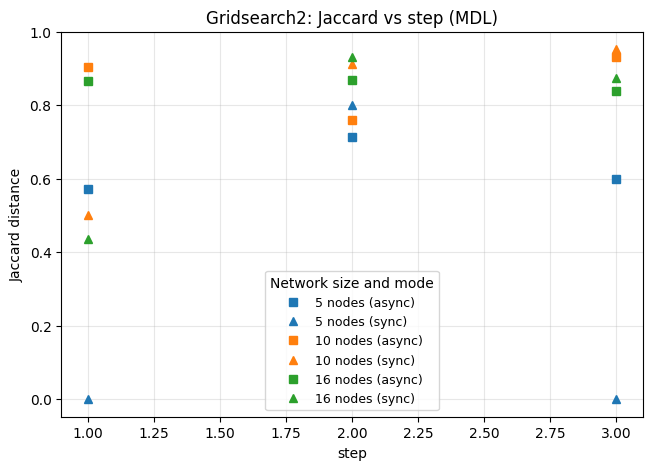

In [48]:
def plot_gs2_jaccard_by_step(results_df: pd.DataFrame, score: str):
    """
    Gridsearch2 plot:
      x-axis: step
      y-axis: JaccardDist
      color: n_nodes
      markers: async='s' (square), sync='^' (triangle)
    """
    gs2 = results_df[
        (results_df["gridsearch"] == "gridsearch2") &
        (results_df["score"] == score)
    ].copy()

    df = gs2[["n_nodes", "mode", "step", "JaccardDist"]].copy()
    df["step"] = df["step"].astype(float)
    df = df.sort_values(["n_nodes", "step", "mode"])

    fig, ax = plt.subplots(figsize=(7.5, 5))

    marker_map = {"a": "s", "s": "^"}  # async square, sync triangle
    mode_label = {"a": "async", "s": "sync"}

    for n in sorted(df["n_nodes"].unique()):
        sub_n = df[df["n_nodes"] == n]

        # Plot async first (to get an automatic color), reuse that color for sync
        color_for_n = None

        sub_a = sub_n[sub_n["mode"] == "a"].sort_values("step")
        if not sub_a.empty:
            line_a, = ax.plot(
                sub_a["step"], sub_a["JaccardDist"],
                marker=marker_map["a"],
                linestyle="None",
                label=f"{int(n)} nodes ({mode_label['a']})"
            )
            color_for_n = line_a.get_color()

        sub_s = sub_n[sub_n["mode"] == "s"].sort_values("step")
        if not sub_s.empty:
            ax.plot(
                sub_s["step"], sub_s["JaccardDist"],
                marker=marker_map["s"],
                linestyle="None",
                color=color_for_n,  # same color as async for this n_nodes
                label=f"{int(n)} nodes ({mode_label['s']})"
            )

    ax.set_xlabel("step")
    ax.set_ylabel("Jaccard distance")
    ax.set_title(f"Gridsearch2: Jaccard vs step ({score})")
    ax.legend(title="Network size and mode", fontsize=9)
    ax.grid(True, alpha=0.3)
    plt.show()

# BDE plot
plot_gs2_jaccard_by_step(results_df, score="BDE")

# MDL plot
plot_gs2_jaccard_by_step(results_df, score="MDL")

In [49]:
gs2 = results_df[results_df["gridsearch"] == "gridsearch2"].copy()

# 1) Mean Jaccard by n_nodes (separately for score)
j_by_nodes = (
    gs2.groupby(["score", "n_nodes"], dropna=False)["JaccardDist"]
       .mean()
       .reset_index()
       .sort_values(["score", "n_nodes"])
)
j_by_nodes

# 2) Mean Jaccard by step (separately for score)
j_by_step = (
    gs2.groupby(["score", "step"], dropna=False)["JaccardDist"]
       .mean()
       .reset_index()
       .sort_values(["score", "step"])
)
j_by_step

# 3) Mean Jaccard by mode (separately for score)
j_by_mode = (
    gs2.groupby(["score", "mode"], dropna=False)["JaccardDist"]
       .mean()
       .reset_index()
       .sort_values(["score", "mode"])
)

In [50]:
j_by_nodes_pivot = j_by_nodes.pivot(index="n_nodes", columns="score", values="JaccardDist").round(4)
j_by_step_pivot  = j_by_step.pivot(index="step", columns="score", values="JaccardDist").round(4)
j_by_mode_pivot  = j_by_mode.pivot(index="mode", columns="score", values="JaccardDist").round(4)

In [51]:
display(j_by_nodes_pivot)

score,BDE,MDL
n_nodes,,
5,0.4476,0.4476
10,0.8254,0.8266
16,0.8145,0.8020


In [52]:
display(j_by_step_pivot)

score,BDE,MDL
step,,
1.0,0.5569,0.5457
2.0,0.8261,0.8311
3.0,0.7045,0.6994


In [53]:
display(j_by_mode_pivot)

score,BDE,MDL
mode,,
a,0.7866,0.7835
s,0.6051,0.6007


In [54]:
def plot_mean_metric(df, x, y, title, x_label=None, y_label=None):
    fig, ax = plt.subplots(figsize=(6.5, 4.5))
    for score in sorted(df["score"].unique()):
        sub = df[df["score"] == score].sort_values(x)
        ax.plot(sub[x], sub[y], marker="o", linestyle="None", label=score)
    ax.set_xlabel(x_label or x)
    ax.set_ylabel(y_label or y)
    ax.set_title(title)
    ax.grid(True, alpha=0.3)
    ax.legend()
    plt.show()

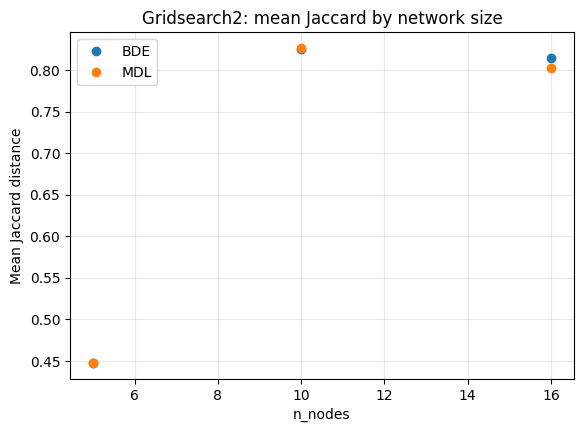

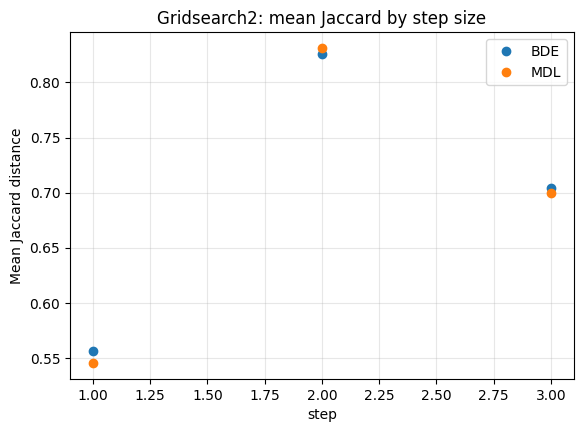

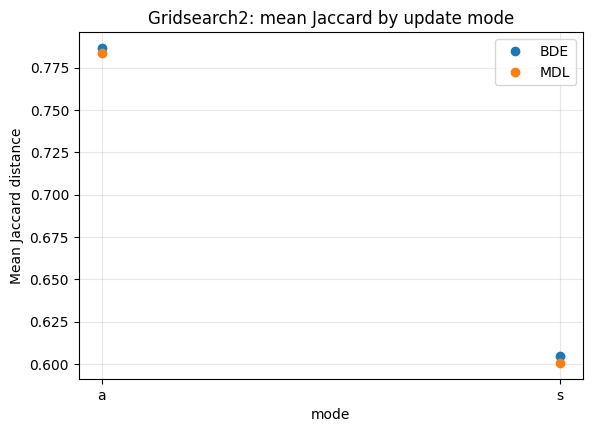

In [55]:
plot_mean_metric(j_by_nodes, x="n_nodes", y="JaccardDist",
                 title="Gridsearch2: mean Jaccard by network size",
                 y_label="Mean Jaccard distance")

plot_mean_metric(j_by_step, x="step", y="JaccardDist",
                 title="Gridsearch2: mean Jaccard by step size",
                 y_label="Mean Jaccard distance")

plot_mean_metric(j_by_mode, x="mode", y="JaccardDist",
                 title="Gridsearch2: mean Jaccard by update mode",
                 y_label="Mean Jaccard distance")

#### Analysis by SHD metric:

In [56]:
# 1) Mean SHD by n_nodes (separately for score)
shd_by_nodes = (
    gs2.groupby(["score", "n_nodes"], dropna=False)["SHD"]
       .mean()
       .reset_index()
       .sort_values(["score", "n_nodes"])
)

# 2) Mean SHD by step (separately for score)
shd_by_step = (
    gs2.groupby(["score", "step"], dropna=False)["SHD"]
       .mean()
       .reset_index()
       .sort_values(["score", "step"])
)

# 3) Mean SHD by mode (separately for score)
shd_by_mode = (
    gs2.groupby(["score", "mode"], dropna=False)["SHD"]
       .mean()
       .reset_index()
       .sort_values(["score", "mode"])
)

In [57]:
shd_by_nodes_pivot = shd_by_nodes.pivot(index="n_nodes", columns="score", values="SHD").round(4)
shd_by_step_pivot  = shd_by_step.pivot(index="step",  columns="score", values="SHD").round(4)
shd_by_mode_pivot  = shd_by_mode.pivot(index="mode",  columns="score", values="SHD").round(4)

In [58]:
display(shd_by_nodes_pivot)

score,BDE,MDL
n_nodes,,
5,2.6667,2.6667
10,20.5000,20.8333
16,26.1667,25.6667


In [59]:
display(shd_by_step_pivot)

score,BDE,MDL
step,,
1.0,14.1667,14.0000
2.0,17.8333,18.1667
3.0,17.3333,17.0000


In [60]:
display(shd_by_mode_pivot)

score,BDE,MDL
mode,,
a,20.3333,20.2222
s,12.5556,12.5556


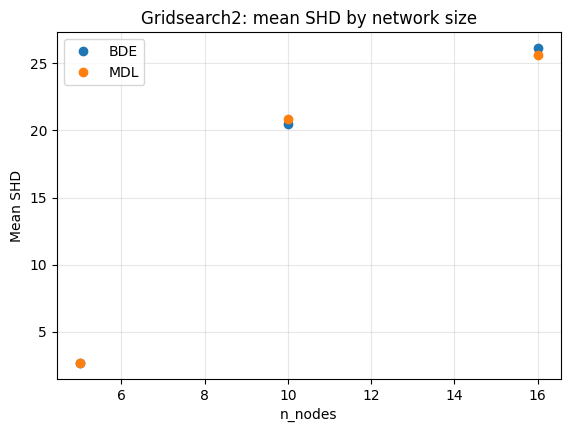

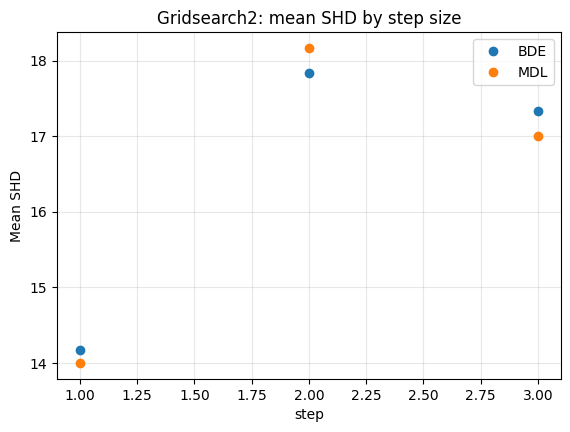

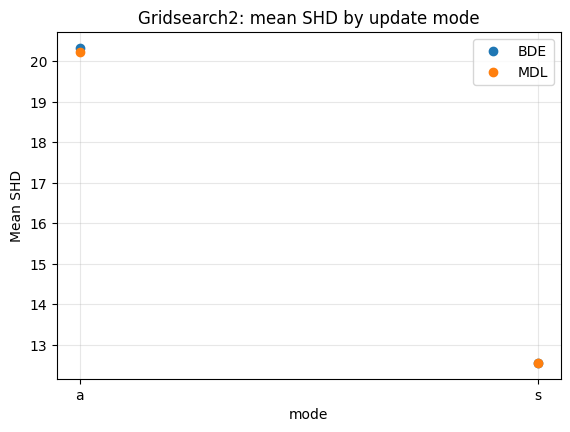

In [61]:
plot_mean_metric(shd_by_nodes, x="n_nodes", y="SHD",
                 title="Gridsearch2: mean SHD by network size",
                 x_label="n_nodes", y_label="Mean SHD")

plot_mean_metric(shd_by_step, x="step", y="SHD",
                 title="Gridsearch2: mean SHD by step size",
                 x_label="step", y_label="Mean SHD")

plot_mean_metric(shd_by_mode, x="mode", y="SHD",
                 title="Gridsearch2: mean SHD by update mode",
                 x_label="mode", y_label="Mean SHD")

### Gridsearch 3 results:

In [66]:
def pivot_gs3_mdl_vs_bde(results_df: pd.DataFrame) -> pd.DataFrame:
    gs3 = results_df[results_df["gridsearch"] == "gridsearch3"].copy()

    summary = (
        gs3.groupby(["mode", "traj_len", "attr_flag", "score"], dropna=False)
           .agg(
               SHD=("SHD", "mean"),
               Jaccard=("JaccardDist", "mean"),
               Precision=("Precision", "mean"),
               Recall=("Recall", "mean"),
               F1=("F1", "mean"),
           )
           .reset_index()
    )

    pivot = summary.pivot_table(
        index=["mode", "traj_len", "attr_flag"],
        columns="score",
        values=["SHD", "Jaccard", "Precision", "Recall", "F1"],
        aggfunc="mean"
    ).sort_index()

    # Enforce metric order
    metric_order = ["SHD", "Jaccard", "Precision", "Recall", "F1"]
    pivot = pivot.reindex(metric_order, axis=1, level=0)

    # Flatten columns into e.g. "SHD (MDL)"
    pivot.columns = [f"{metric} ({score})" for (metric, score) in pivot.columns]
    return pivot.round(4)

gs3_pivot = pivot_gs3_mdl_vs_bde(results_df)
gs3_pivot

SHD (BDE)  SHD (MDL)  Jaccard (BDE)  Jaccard (MDL)  \
mode traj_len attr_flag                                                       
a    10.0     0.0             28.0       27.0         0.9655         0.9310   
              1.0             24.0       24.0         0.8276         0.8276   
     20.0     0.0             27.0       26.0         0.9310         0.8966   
              1.0             22.0       22.0         0.7586         0.7586   
     50.0     0.0             23.0       21.0         0.7931         0.7000   
              1.0             19.0       19.0         0.6552         0.6552   
s    10.0     0.0             11.0       11.0         0.5500         0.5500   
              1.0             10.0       10.0         0.5000         0.5000   
     20.0     0.0              8.0        7.0         0.4000         0.3500   
              1.0              7.0        6.0         0.3500         0.3000   
     50.0     0.0              3.0        5.0         0.1500         0.2174   
              1.0              4.0        5.0         0.2000         0.2500   

                         Precision (BDE)  Precision (MDL)  Recall (BDE)  \
mode traj_len attr_flag                                                   
a    10.0     0.0                 0.1000           0.1818          0.05   
              1.0                 0.3571           0.3571          0.25   
     20.0     0.0                 0.1818           0.2500          0.10   
              1.0                 0.4375           0.4375          0.35   
     50.0     0.0                 0.4000           0.4737          0.30   
              1.0                 0.5263           0.5263          0.50   
s    10.0     0.0                 1.0000           1.0000          0.45   
              1.0                 1.0000           1.0000          0.50   
     20.0     0.0                 1.0000           1.0000          0.60   
              1.0                 1.0000           1.0000          0.65   
     50.0     0.0                 1.0000           0.8571          0.85   
              1.0                 1.0000           1.0000          0.80   

                         Recall (MDL)  F1 (BDE)  F1 (MDL)  
mode traj_len attr_flag                                    
a    10.0     0.0                0.10    0.0667    0.1290  
              1.0                0.25    0.2941    0.2941  
     20.0     0.0                0.15    0.1290    0.1875  
              1.0                0.35    0.3889    0.3889  
     50.0     0.0                0.45    0.3429    0.4615  
              1.0                0.50    0.5128    0.5128  
s    10.0     0.0                0.45    0.6207    0.6207  
              1.0                0.50    0.6667    0.6667  
     20.0     0.0                0.65    0.7500    0.7879  
              1.0                0.70    0.7879    0.8235  
     50.0     0.0                0.90    0.9189    0.8780  
              1.0                0.75    0.8889    0.8571

#### Analysis by Jaccard metric:

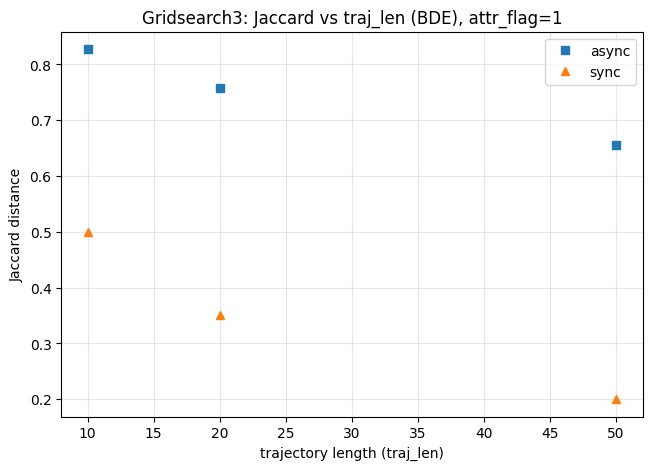

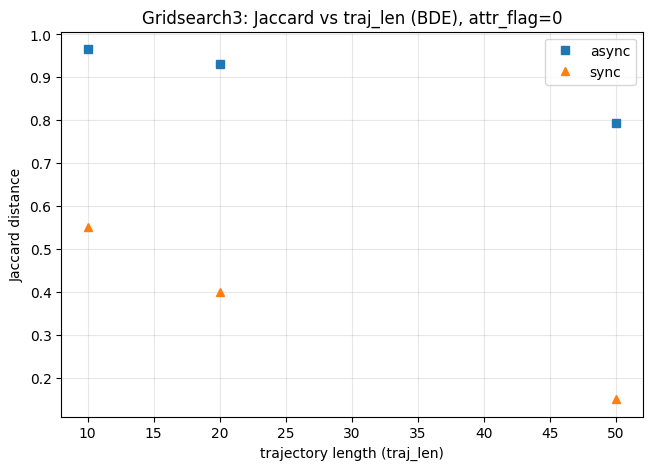

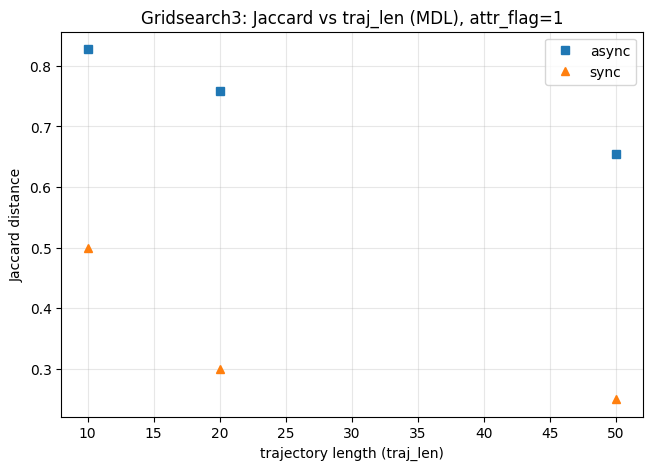

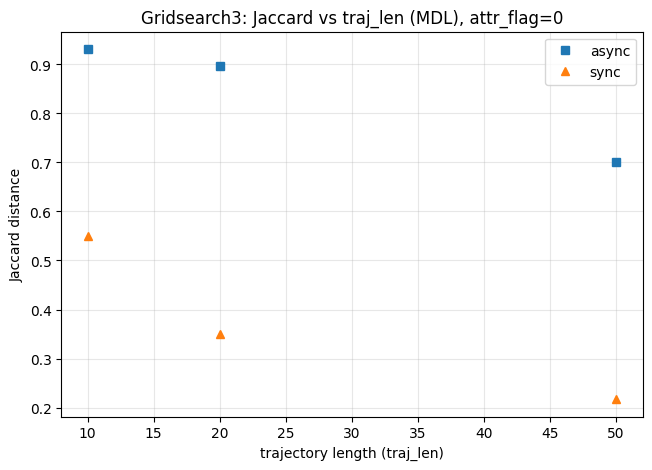

In [82]:
def plot_gs3_jaccard_vs_trajlen(results_df: pd.DataFrame, score: str, attr_flag: int):
    """
    Gridsearch3 plot:
      x-axis: traj_len
      y-axis: JaccardDist
      markers: async='s' (square), sync='^' (triangle)
      filtered by: score in {BDE, MDL} and attr_flag in {0,1}
    """
    df = results_df[
        (results_df["gridsearch"] == "gridsearch3") &
        (results_df["score"] == score) &
        (results_df["attr_flag"] == attr_flag)
    ].copy()

    df["traj_len"] = df["traj_len"].astype(int)

    fig, ax = plt.subplots(figsize=(7.5, 5))

    marker_map = {"a": "s", "s": "^"}  # async square, sync triangle
    label_map  = {"a": "async", "s": "sync"}

    for mode in ["a", "s"]:
        sub = df[df["mode"] == mode].sort_values("traj_len")
        if sub.empty:
            continue
        ax.plot(
            sub["traj_len"],
            sub["JaccardDist"],
            marker=marker_map[mode],
            linestyle="None",
            label=label_map[mode],
        )

    ax.set_xlabel("trajectory length (traj_len)")
    ax.set_ylabel("Jaccard distance")
    ax.set_title(f"Gridsearch3: Jaccard vs traj_len ({score}), attr_flag={attr_flag}")
    ax.grid(True, alpha=0.3)
    ax.legend()
    plt.show()

# 1) BDE, large attractor_fraction (attr_flag=1)
plot_gs3_jaccard_vs_trajlen(results_df, score="BDE", attr_flag=1)

# 2) BDE, small attractor_fraction (attr_flag=0)
plot_gs3_jaccard_vs_trajlen(results_df, score="BDE", attr_flag=0)

# 3) MDL, large attractor_fraction (attr_flag=1)
plot_gs3_jaccard_vs_trajlen(results_df, score="MDL", attr_flag=1)

# 4) MDL, small attractor_fraction (attr_flag=0)
plot_gs3_jaccard_vs_trajlen(results_df, score="MDL", attr_flag=0)

In [68]:
gs3 = results_df[results_df["gridsearch"] == "gridsearch3"].copy()

# Mean Jaccard by trajectory length (separately for score)
gs3_j_by_traj = (
    gs3.groupby(["score", "traj_len"], dropna=False)["JaccardDist"]
       .mean()
       .reset_index()
       .sort_values(["traj_len", "score"])
)

# Mean Jaccard by mode (separately for score)
gs3_j_by_mode = (
    gs3.groupby(["score", "mode"], dropna=False)["JaccardDist"]
       .mean()
       .reset_index()
       .sort_values(["mode", "score"])
)

# Mean Jaccard by attractor fraction flag (separately for score)
gs3_j_by_attr = (
    gs3.groupby(["score", "attr_flag"], dropna=False)["JaccardDist"]
       .mean()
       .reset_index()
       .sort_values(["attr_flag", "score"])
)

In [69]:
gs3_j_by_traj_pivot = gs3_j_by_traj.pivot(index="traj_len", columns="score", values="JaccardDist").round(4)
gs3_j_by_mode_pivot = gs3_j_by_mode.pivot(index="mode", columns="score", values="JaccardDist").round(4)
gs3_j_by_attr_pivot = gs3_j_by_attr.pivot(index="attr_flag", columns="score", values="JaccardDist").round(4)

In [70]:
display(gs3_j_by_traj_pivot)

score,BDE,MDL
traj_len,,
10.0,0.7108,0.7022
20.0,0.6099,0.5763
50.0,0.4496,0.4556


In [71]:
display(gs3_j_by_mode_pivot)

score,BDE,MDL
mode,,
a,0.8218,0.7948
s,0.3583,0.3612


In [72]:
display(gs3_j_by_attr_pivot)

score,BDE,MDL
attr_flag,,
0.0,0.6316,0.6075
1.0,0.5486,0.5486


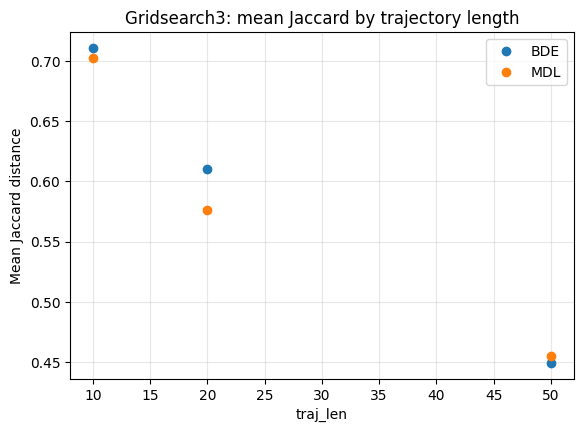

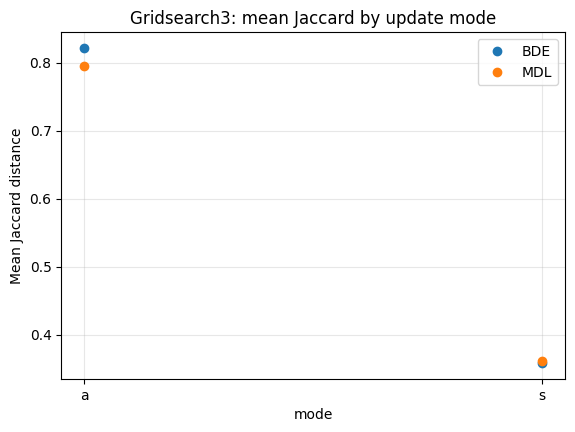

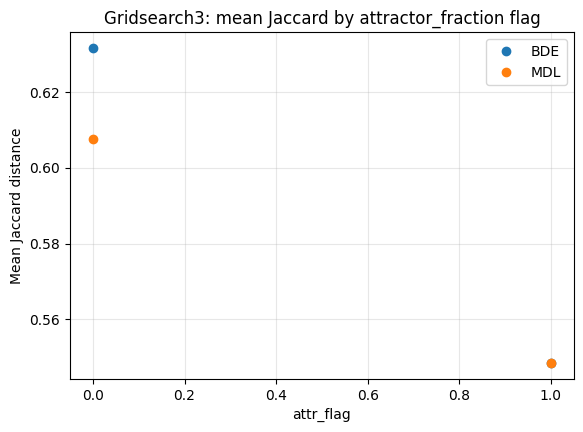

In [73]:
plot_mean_metric(
    gs3_j_by_traj, x="traj_len", y="JaccardDist",
    title="Gridsearch3: mean Jaccard by trajectory length",
    x_label="traj_len", y_label="Mean Jaccard distance"
)

plot_mean_metric(
    gs3_j_by_mode, x="mode", y="JaccardDist",
    title="Gridsearch3: mean Jaccard by update mode",
    x_label="mode", y_label="Mean Jaccard distance"
)

plot_mean_metric(
    gs3_j_by_attr, x="attr_flag", y="JaccardDist",
    title="Gridsearch3: mean Jaccard by attractor_fraction flag",
    x_label="attr_flag", y_label="Mean Jaccard distance"
)

#### Analysis by SHD metric:

In [74]:
# Mean SHD by trajectory length (separately for score)
gs3_shd_by_traj = (
    gs3.groupby(["score", "traj_len"], dropna=False)["SHD"]
       .mean()
       .reset_index()
       .sort_values(["traj_len", "score"])
)

# Mean SHD by mode (separately for score)
gs3_shd_by_mode = (
    gs3.groupby(["score", "mode"], dropna=False)["SHD"]
       .mean()
       .reset_index()
       .sort_values(["mode", "score"])
)

# Mean SHD by attractor fraction flag (separately for score)
gs3_shd_by_attr = (
    gs3.groupby(["score", "attr_flag"], dropna=False)["SHD"]
       .mean()
       .reset_index()
       .sort_values(["attr_flag", "score"])
)

In [76]:
gs3_shd_by_traj_pivot = gs3_shd_by_traj.pivot(index="traj_len", columns="score", values="SHD").round(4)
gs3_shd_by_mode_pivot = gs3_shd_by_mode.pivot(index="mode", columns="score", values="SHD").round(4)
gs3_shd_by_attr_pivot = gs3_shd_by_attr.pivot(index="attr_flag", columns="score", values="SHD").round(4)

In [77]:
display(gs3_shd_by_traj_pivot)

score,BDE,MDL
traj_len,,
10.0,18.25,18.00
20.0,16.00,15.25
50.0,12.25,12.50


In [78]:
display(gs3_shd_by_mode_pivot)

score,BDE,MDL
mode,,
a,23.8333,23.1667
s,7.1667,7.3333


In [79]:
display(gs3_shd_by_attr_pivot)

score,BDE,MDL
attr_flag,,
0.0,16.6667,16.1667
1.0,14.3333,14.3333


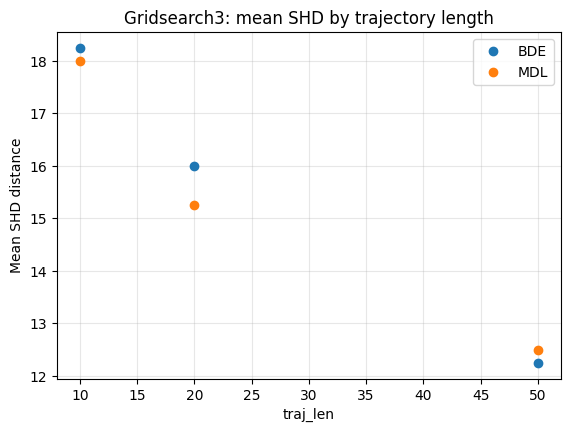

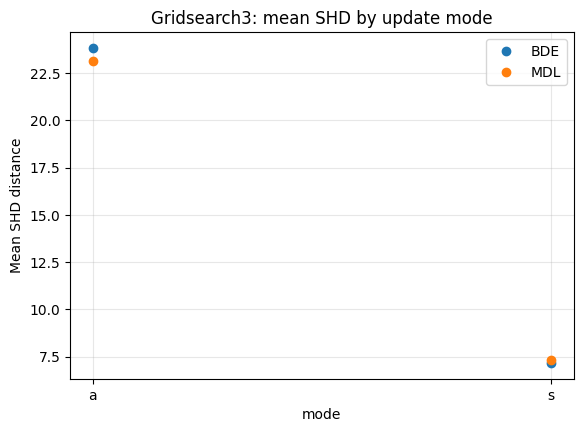

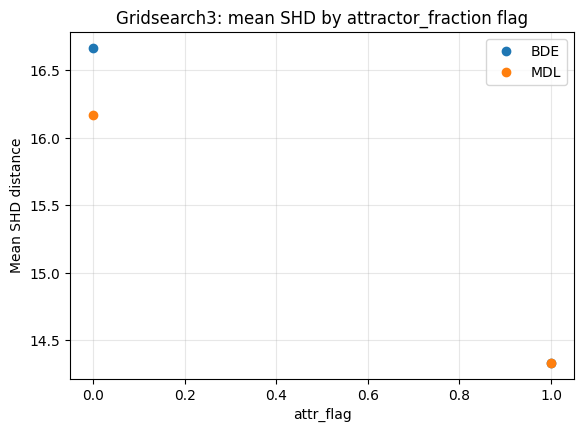

In [80]:
plot_mean_metric(
    gs3_shd_by_traj, x="traj_len", y="SHD",
    title="Gridsearch3: mean SHD by trajectory length",
    x_label="traj_len", y_label="Mean SHD distance"
)

plot_mean_metric(
    gs3_shd_by_mode, x="mode", y="SHD",
    title="Gridsearch3: mean SHD by update mode",
    x_label="mode", y_label="Mean SHD distance"
)

plot_mean_metric(
    gs3_shd_by_attr, x="attr_flag", y="SHD",
    title="Gridsearch3: mean SHD by attractor_fraction flag",
    x_label="attr_flag", y_label="Mean SHD distance"
)

## 5. Results for reconstructed network in Part II of the project:

Assume we have access to "drosophilia_bn_edges.txt" (ground truth) and "small_out_MDL.sif" (reconstruction)

In [62]:
_ = files.upload()

Saving drosophilia_bn_edges.txt to drosophilia_bn_edges.txt


In [63]:
_ = files.upload()

Saving small_out_MDL.sif to small_out_MDL.sif


In [64]:
GT_PATH = "drosophilia_bn_edges.txt"
PRED_PATH = "small_out_MDL.sif"

# Ground truth from GT_PATH:
with open(GT_PATH, "r", encoding="utf-8", errors="replace") as f:
    e_true = {
        (parts[0], parts[1])
        for line in f
        if (parts := line.strip().split()) and not line.strip().startswith("#") and len(parts) >= 2
    }

rows = read_sif_edges(PRED_PATH)
e_pred_thr = binarize_edges(rows, method="threshold", threshold=0.5)

In [65]:
def compute_metrics(e_pred, method_name, threshold=None, topk=None):
    SHD = shd(e_true, e_pred)
    J = jaccard_distance(e_true, e_pred)
    P, R, F1 = precision_recall_f1(e_true, e_pred)
    return {
        "dataset": "drosophila",
        "score": "MDL",
        "binarize_method": method_name,
        "threshold": threshold,
        "topk": topk,
        "n_true_edges": len(e_true),
        "n_pred_edges": len(e_pred),
        "SHD": SHD,
        "JaccardDist": J,
        "Precision": P,
        "Recall": R,
        "F1": F1,
    }

drosophila_results = pd.DataFrame([
    compute_metrics(e_pred_thr, method_name="threshold", threshold=0.5),
]).round(4)

drosophila_results

,dataset,score,binarize_method,threshold,topk,n_true_edges,n_pred_edges,SHD,JaccardDist,Precision,Recall,F1
0,drosophila,MDL,threshold,0.5,None,9,8,1,0.1111,1.0,0.8889,0.9412
